In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


## Question 1 & 2


- Do a regression to estimate the fixed effect of each group. We assume that there is one single linear coefficient for all the data, plus the fixed effect of each group.
- Use the file homework_2.1.csv.  The variables G1, G2, and G3 are the outcomes and the time is the treatment.


In [12]:
df_2_1 = pd.read_csv('homework_2.1.csv')

In [13]:
# Reshape to long format
df_long = df_2_1.melt(id_vars=['time'], value_vars=['G1', 'G2', 'G3'], 
                 var_name='group', value_name='outcome')

# Fit fixed effects regression: outcome ~ time + group
model_2_1 = smf.ols('outcome ~ time + C(group)', data=df_long).fit()
print(model_2_1.summary())

# Display estimated fixed effects for each group
fe = model_2_1.params.filter(like='C(group)')
print('\nFixed effects for each group:')
print(fe)

# Display the coefficient for time
print(f"\nCoefficient for time: {model_2_1.params['time']}")

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     44.55
Date:                Sat, 14 Jun 2025   Prob (F-statistic):           8.72e-24
Time:                        13:15:17   Log-Likelihood:                -216.89
No. Observations:                 300   AIC:                             441.8
Df Residuals:                     296   BIC:                             456.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0786      0.071      1.

## Question 3-5

Given a data set, create a bootstrap simulation to try different possibilities. 
Use the file homework_2.2.csv 

In [14]:
df_2_2 = pd.read_csv('homework_2.2.csv')

Bootstrap mean difference: 2.924
95% CI: [2.569, 3.285]


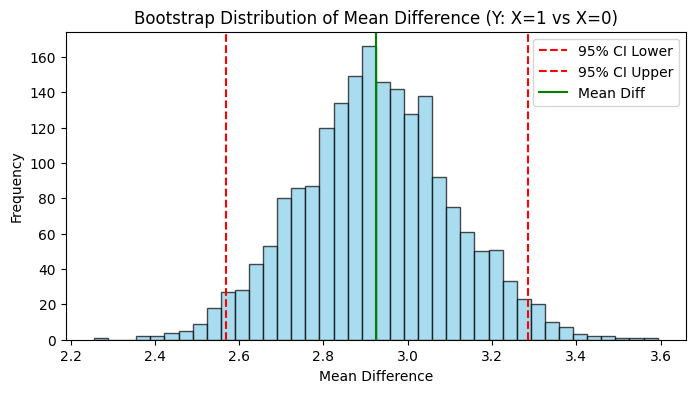

In [15]:
# Bootstrap simulation for mean difference in Y between X=1 and X=0
def bootstrap_mean_diff(df, n_bootstrap=1000, random_state=42):
    np.random.seed(random_state)
    diffs = []
    group1 = df[df['X'] == 1]['Y'].values
    group0 = df[df['X'] == 0]['Y'].values
    n1 = len(group1)
    n0 = len(group0)
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample0 = np.random.choice(group0, size=n0, replace=True)
        diffs.append(sample1.mean() - sample0.mean())
    return np.array(diffs)

# Run bootstrap
boot_diffs = bootstrap_mean_diff(df_2_2, n_bootstrap=2000)

# Calculate 95% confidence interval
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)
mean_diff = boot_diffs.mean()

print(f"Bootstrap mean difference: {mean_diff:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# Plot the bootstrap distribution
plt.figure(figsize=(8,4))
plt.hist(boot_diffs, bins=40, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(ci_lower, color='red', linestyle='--', label='95% CI Lower')
plt.axvline(ci_upper, color='red', linestyle='--', label='95% CI Upper')
plt.axvline(mean_diff, color='green', linestyle='-', label='Mean Diff')
plt.title('Bootstrap Distribution of Mean Difference (Y: X=1 vs X=0)')
plt.xlabel('Mean Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [16]:
mean_treated = df_2_2[df_2_2['X'] == 1]['Y'].mean()
mean_untreated = df_2_2[df_2_2['X'] == 0]['Y'].mean()
simple_diff = mean_treated - mean_untreated

print(f"Mean outcome (Treated, X=1): {mean_treated:.3f}")
print(f"Mean outcome (Untreated, X=0): {mean_untreated:.3f}")
print(f"Simple difference in means (Treated - Untreated): {simple_diff:.3f}")

Mean outcome (Treated, X=1): 7.843
Mean outcome (Untreated, X=0): 4.922
Simple difference in means (Treated - Untreated): 2.921


## Homework Reflection

1. Invent an example situation that would use fixed effects.

**Example:** Does lowering the room price increase hotel occupancy rates?
Each hotel has unique, unobserved characteristics that affect its occupancy rate, such as reputation, management quality, and location. These don't change over time, so you treat them as fixed effects to isolate the effect of room price changes. From this, you can learn that within the same hotel, lowering the price leads to higher occupancy, even after accounting for the hotel's brand, location, or rating.

2. Write a Python program that performs a bootstrap simulation to find the variance in the mean of the Pareto distribution when different samples are taken. Explain what you had to do for this.  As you make the full sample size bigger (for the same distribution), what happens to the variance of the mean of the samples?  Does it stay about the same, get smaller, or get bigger?

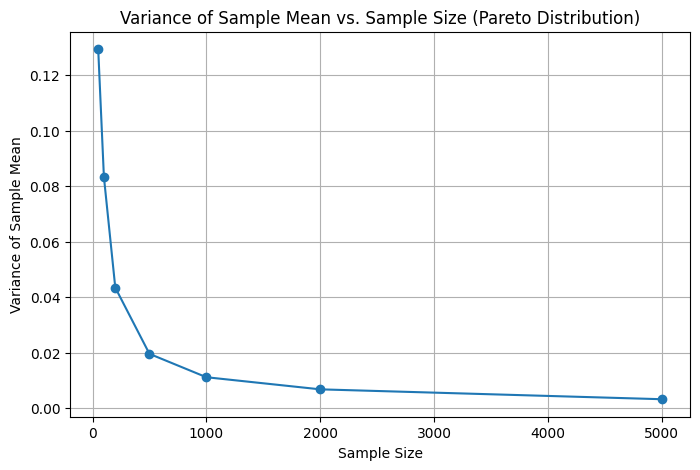

In [17]:
# Efficient bootstrap simulation for variance of sample mean from Pareto distribution
def bootstrap_pareto_mean_variance(shape, sample_sizes, n_bootstrap=1000, random_state=42):
    np.random.seed(random_state)
    mean_variances = []
    for n in sample_sizes:
        # Generate all bootstrap samples at once for efficiency
        samples = np.random.pareto(shape, size=(n_bootstrap, n))
        means = samples.mean(axis=1)
        mean_variances.append(np.var(means))
    return mean_variances

# Parameters
shape = 2  # Shape parameter for Pareto distribution  
sample_sizes = [50, 100, 200, 500, 1000, 2000, 5000]

# Run efficient bootstrap
mean_variances = bootstrap_pareto_mean_variance(shape, sample_sizes, n_bootstrap=1000)

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, mean_variances, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Variance of Sample Mean')
plt.title('Variance of Sample Mean vs. Sample Size (Pareto Distribution)')
plt.grid(True)
plt.show()


I set up a function that allows me to set some parameters to keep the distribution the same. I can control the number of iterations (the bootstrap) and the number of samples. The for loop iterates over the number of iterations, drawing from the Pareto distribution, the number of samples. It then calculates the variance and stores it in the variances array. 

As the sample size increases, the variance of the mean goes down. This happens because the sample mean becomes more stable as the original sample grows; you’re drawing bootstrap samples from a more accurate population representation.